# Deep Hedging

In [77]:
# Importing Relevant Packages
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import pandas as pd, scipy.stats as stats
from tqdm import tqdm
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from scipy.optimize import minimize_scalar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simulators

In [86]:
class bsGenerator:
    '''Object that generates price Trajectories using Black-Scholes-Merton Model (Geometric Brownian Motion).

    Args:
        initialPrice (float): The initial Stock Price
        volatility (float): The (constant) volatility constant of stock price
        timeToExpiry (float): Time in years until expiry
        riskFreeRate: The (constant) risk-free rate at which trader can borrow and lend
        numTradingDates: Discrete number of dates for which price must be simulated.
        numBatches: the number of batches that will be run
        batchSize: Number of path trajectories that will be simulated in each batch
        
    Output: 
        Torch Float Tensor of simulated Brownian Motion Path trajectories of size (batchSize, numTradingDates)
        
        '''
    def __init__(self
                 , initialPrice = 100.0
                 , volatility = 0.2
                 , timeToExpiry = 1.0
                 , riskFreeRate = 0.0
                 , numTradingDates = 100
                 , numBatches = 100
                 , batchSize = 128
                ):
        
        self.initialPrice = initialPrice
        self.volatility = volatility
        self.timeToExpiry = timeToExpiry
        self.riskFreeRate = riskFreeRate
        self.numTradingDates = numTradingDates
        self.deltaT = self.timeToExpiry / self.numTradingDates
        
        self.numBatches = numBatches
        self.batchSize = batchSize
        self.batchNo = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.batchNo >= self.numBatches:
            raise StopIteration()
        self.batchNo += 1
        
        # Black Scholes Paths created using geometric Brownian Motion
        # Closed form solution for Price Path
        logS = ((self.riskFreeRate - 0.5 * self.volatility **2) * self.deltaT +
                self.volatility * np.sqrt(self.deltaT) * np.random.normal(loc = 0.0, scale = 1.0
                                                                         , size = (self.numTradingDates + 1, self.batchSize)
                                                                         )
               )
        logS[0,] = np.zeros((1, self.batchSize)) # Set paths to start at initial price.
        logS = np.cumsum(logS, axis = 0)
        print(logS)
        return torch.from_numpy(self.initialPrice * np.exp(logS).transpose()).type(torch.FloatTensor) # working in rows not columns


In [69]:
def hestonModel(S_0, v_0, T, r, theta, kappa, xi, rho, steps, no_paths, return_vol = False):
    """Function generating stock price trajectories in Heston Model

    Args:
        S_0 (float): the initial stock price
        v_0 (float): the initial volatility
        T (int): time period
        r (float): the risk free rate
        theta (float): the long-term price variance
        kappa (float): the rate of reversion to theta
        xi (float): the volatility of sqrt(V_t)
        rho (float): the correlation of Brownian motions
        steps (int): number of steps/days
        no_paths (int): number of paths
        return_vol (bool, optional): check whether volatility should be returned. Defaults to False.

    Returns:
        array: The list of stock prices
    """
    dt = T/steps
    size = (no_paths, steps)
    prices = np.zeros(size)
    vols = np.zeros(size)
    S_t = S_0
    v_t = v_0
    for t in range(steps):
        W_t = np.random.multivariate_normal(np.array([0,0]),
                                     cov = np.array([[1, rho],[rho, 1]]),
                                     size = no_paths) * np.sqrt(dt)
        
        S_t = S_t * (np.exp((r - v_t/2)*dt + np.sqrt(v_t)*W_t[:,0]))
        v_t = np.abs(v_t + kappa*(theta - v_t)*dt + xi*np.sqrt(v_t)*W_t[:,1])
        prices[:,t] = S_t
        vols[:,t] = v_t
        
    if return_vol:
        return prices, vols
    
    return prices

'''Need to transform this function into a torch tensor object to use in PyTorch.'''

'Need to transform this function into a torch tensor object to use in PyTorch.'

# Simple Feed-Forward NN Strategy


In [80]:
class Strategy(nn.Module):
    def __init__(self, hiddenNodes, numTradingDates):
        super(Strategy, self).__init__()
        
        # Price of the Options
        self.price = nn.Parameter(torch.tensor(0, dtype = torch.float32))
        
        # Trading/Hedging Strategy
        self.steps = nn.ModuleList()
        for i in range(numTradingDates):
            h_i = nn.Sequential(nn.Linear(1, hiddenNodes)
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes, hiddenNodes)
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes, 1)
                               )
            
            self.steps.append(h_i)
        
    def forward(self, x): # x is a subset of paths of price process
        dS = torch.diff(x)
        ret = torch.zeros_like(dS[:,0]) + self.price
        
        for i in range(len(self.steps)):
            logS = torch.log(x[:,i])
            h_i = self.steps[i]
            H_i = h_i(logS.unsqueeze(-1)) # separates logS (single list) values into list of single-valued lists.
            ret += dS[:,i] * H_i.flatten()
            return ret
        

In [71]:
class fuckyou():
    def __init__(self, hiddenNodes):
        
        self.steps = nn.ModuleList()
        for i in range(22):
            h_i = nn.Sequential(nn.Linear(1, hiddenNodes)
                                , nn.ReLU()
                                , nn.Linear(hiddenNodes, 1)
                               )
            self.steps.append(h_i)
            
len(fuckyou(100).steps)


22

The trading strategy is determined using a feed-forward neural network consisting of a single hidden layer and 100 nodes in the layer. Using Geometric Brownian Motion simulations below, we will train the strategy to minimise 

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.32749677e-02  6.71460085e-02  6.62316136e-03 ... -1.13402739e-02
  -7.24589206e-03 -7.87021818e-02]
 [ 7.14373487e-02  3.98748594e-02  5.92891405e-02 ...  4.68795200e-05
  -9.67622761e-02 -3.73880408e-02]
 ...
 [ 3.75808813e-01  2.97352696e-01 -1.27058914e-02 ...  3.25900577e-01
  -1.23034491e-01  1.95132858e-01]
 [ 3.07821896e-01  3.90583918e-01 -4.97988536e-02 ...  3.74342504e-01
  -1.18137194e-01  2.23284128e-01]
 [ 2.82492791e-01  4.24939013e-01 -1.38446182e-01 ...  3.89072177e-01
  -1.27599014e-01  2.78975111e-01]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.04200775 -0.07080816  0.10979947 ... -0.05060339 -0.0043162
  -0.02316118]
 [-0.00470252 -0.03260088  0.02618884 ... -0.08530183  0.02207076
  -0.04067603]
 ...
 [-0.08827581 -0.17129567  0.43423111 ... -0.23765614  0.36593768
   0.31209571]
 [-0.14558203 -0.20734107  0.25983527 ... -0

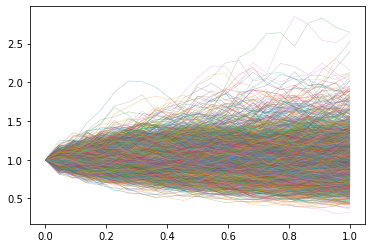

In [87]:
riskFreeRate = 0.0
volatility = 0.3
timeToExpiry = 1
initialPrice = 1
numTradingDates = 22
batchSize = 2000
numBatches = 50

pathSimulations = bsGenerator(riskFreeRate = riskFreeRate
                             , volatility = volatility
                             , timeToExpiry = timeToExpiry
                             , initialPrice = initialPrice
                             , numTradingDates = numTradingDates
                             , batchSize = batchSize
                             , numBatches = numBatches)

for S in pathSimulations:
    pass
for i in range(batchSize):
    plt.plot(np.linspace(0,1,numTradingDates + 1), S[i,:], alpha = 0.5, linewidth = 0.4)
plt.show()

In [82]:
def claim(x):
    return torch.max(x, initialPrice * torch.ones_like(x)) - initialPrice

50it [00:00, 197.80it/s]


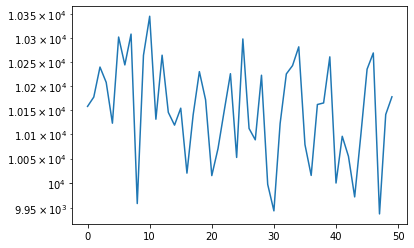

In [83]:
progress = []
loss = nn.MSELoss()
strat = Strategy(100, numTradingDates)
opt = torch.optim.Adam(strat.parameters(), lr = 0.01)

for S in tqdm(bsGenerator(numBatches = 50, batchSize = 2000, numTradingDates = numTradingDates)):
    opt.zero_grad()
    err = loss(strat(S), claim(S[:, -1]))
    progress.append(err.item())
    err.backward()
    opt.step()
    
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(np.array(progress))
plt.show()

2000
tensor([[1.0741],
        [1.0741],
        [1.0741],
        ...,
        [1.0741],
        [1.0741],
        [1.0741]])
2000
tensor([[1.0741],
        [1.0741],
        [1.0741],
        ...,
        [1.0741],
        [1.0741],
        [1.0741]])


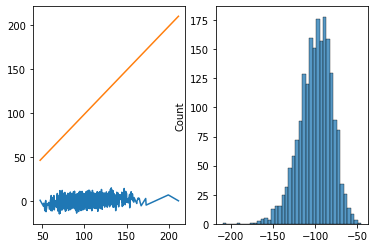

In [76]:
x = torch.linspace(0,20,100)
fig, ax = plt.subplots(1,2)
with torch.no_grad():
    sns.histplot(strat(S) - claim(S[:,-1]), ax = ax[1])
    sns.lineplot(x = S[:,-1], y = strat(S), ax=ax[0] )
    sns.lineplot(x = S[:,-1], y = claim(S[:,-1]), ax=ax[0] )
plt.show()